In [10]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.optim as optim

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [12]:
import torch
from diffusers import StableDiffusionPipeline
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [13]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

In [14]:
print("Using device:", device)

Using device: cuda:5


In [15]:
train_dir = "data/train_data"
val_dir = "data/validation_data"
test_dir = "data/test_data"
csv_path = "final data.csv"

In [16]:
df_labels = pd.read_csv(csv_path)
print(df_labels.head())

        Image Index  Finding Labels  Label
0  00017750_004.png  ['No Finding']      0
1  00017750_005.png  ['No Finding']      0
2  00017750_006.png  ['No Finding']      0
3  00017751_002.png  ['No Finding']      0
4  00017751_003.png  ['No Finding']      0


In [17]:
def get_filenames_and_labels(df, folder):
    filenames = df['Image Index'].tolist()
    labels = df['Label'].tolist()
    paths = [os.path.join(folder, fname) for fname in filenames]
    return paths, labels

In [18]:
train_paths, train_labels = get_filenames_and_labels(
    df_labels[df_labels['Image Index'].isin(os.listdir(train_dir))], train_dir)
val_paths, val_labels = get_filenames_and_labels(
    df_labels[df_labels['Image Index'].isin(os.listdir(val_dir))], val_dir)
test_paths, test_labels = get_filenames_and_labels(
    df_labels[df_labels['Image Index'].isin(os.listdir(test_dir))], test_dir)

In [19]:
img_height, img_width = 256, 256
batch_size = 32

In [20]:
class ChestXrayDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        image = image.convert("L").convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        one_hot_label = torch.zeros(2)
        one_hot_label[label] = 1.0
        return image, one_hot_label

In [21]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Adjust resolution as needed
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Expecting range [-1, 1]
])

In [33]:
train_dataset = ChestXrayDataset(train_paths, train_labels, transform=transform)
val_dataset = ChestXrayDataset(val_paths, val_labels, transform=transform)
test_dataset = ChestXrayDataset(test_paths, test_labels, transform=transform)

In [34]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [35]:
def show_images(images, labels):
    grid_img = torchvision.utils.make_grid(images, nrow=3, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title("Sample Images")
    plt.axis('off')
    plt.show()

Images shape: torch.Size([32, 3, 32, 32])


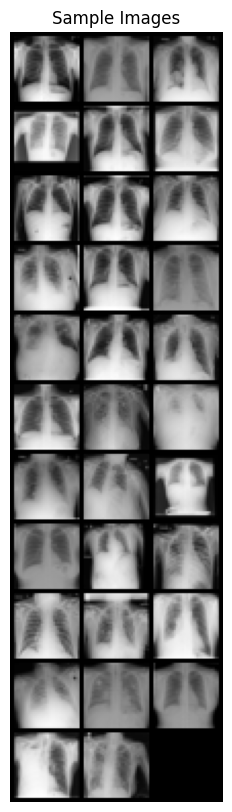

In [36]:
for images, labels in train_loader:
    print("Images shape:", images.shape)
    show_images(images, labels)
    break

In [8]:
from diffusers import DDPMPipeline
import torch

In [9]:
pipe = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipe = pipe.to(device)

Loading pipeline components...:   0%|                                                                                                                                               | 0/2 [00:00<?, ?it/s]An error occurred while trying to fetch /home/spring2024/sc9422/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /home/spring2024/sc9422/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.61it/s]


In [29]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from diffusers import DDPMPipeline
from torch.optim import AdamW

In [30]:
unet = pipe.unet
optimizer = AdamW(unet.parameters(), lr=1e-5)

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [32]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [37]:
T = pipe.scheduler.num_train_timesteps

/home/spring2024/sc9422/miniconda3/envs/idai780/lib/python3.11/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


In [65]:
num_epochs = 20

In [66]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(device)
        # Sample random timesteps for each image in the batch
        timesteps = torch.randint(0, T, (images.size(0),), device=device).long()
        noise = torch.randn_like(images)
        noisy_images = pipe.scheduler.add_noise(images, noise, timesteps)
        noise_pred = unet(noisy_images, timesteps).sample
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | Step [{batch_idx}/{len(train_loader)}] | Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")

Epoch [1/20] | Step [0/881] | Loss: 0.0095
Epoch [1/20] | Step [100/881] | Loss: 0.0084
Epoch [1/20] | Step [200/881] | Loss: 0.0188
Epoch [1/20] | Step [300/881] | Loss: 0.0188
Epoch [1/20] | Step [400/881] | Loss: 0.0120
Epoch [1/20] | Step [500/881] | Loss: 0.0080
Epoch [1/20] | Step [600/881] | Loss: 0.0196
Epoch [1/20] | Step [700/881] | Loss: 0.0181
Epoch [1/20] | Step [800/881] | Loss: 0.0171
Epoch [1/20] Average Loss: 0.0121
Epoch [2/20] | Step [0/881] | Loss: 0.0073
Epoch [2/20] | Step [100/881] | Loss: 0.0131
Epoch [2/20] | Step [200/881] | Loss: 0.0135
Epoch [2/20] | Step [300/881] | Loss: 0.0194
Epoch [2/20] | Step [400/881] | Loss: 0.0103
Epoch [2/20] | Step [500/881] | Loss: 0.0098
Epoch [2/20] | Step [600/881] | Loss: 0.0090
Epoch [2/20] | Step [700/881] | Loss: 0.0102
Epoch [2/20] | Step [800/881] | Loss: 0.0183
Epoch [2/20] Average Loss: 0.0118
Epoch [3/20] | Step [0/881] | Loss: 0.0148
Epoch [3/20] | Step [100/881] | Loss: 0.0132
Epoch [3/20] | Step [200/881] | Loss: 

In [67]:
import os
import torch
from torchvision.transforms import ToPILImage

In [68]:
torch.save(pipe.unet.state_dict(), "fine_tuned_ddpm_unet_1.pth")
print("Fine-tuned UNet saved.")

Fine-tuned UNet saved.


In [70]:
save_path = "fine_tuned_ddpm_unet_1.pth"
state_dict = torch.load(save_path, map_location=device)
pipe.unet.load_state_dict(state_dict)
pipe.unet.eval()  # set to evaluation mode
print("Fine-tuned UNet loaded successfully!")

Fine-tuned UNet loaded successfully!


In [71]:
T = pipe.scheduler.num_train_timesteps  # Typically 1000 timesteps
batch_size = 15  # Number of images to generate
image_shape = (batch_size, 3, 32, 32)

In [72]:
x = torch.randn(image_shape, device=device)

In [73]:
with torch.no_grad():
    for t in reversed(range(T)):
        t_tensor = torch.full((batch_size,), t, device=device, dtype=torch.long)
        noise_pred = pipe.unet(x, t_tensor).sample
        step_output = pipe.scheduler.step(noise_pred, t, sample=x)
        x = step_output.prev_sample

In [74]:
to_pil = ToPILImage()
save_dir = "update_generated_images"
os.makedirs(save_dir, exist_ok=True)


In [75]:
for idx, img in enumerate(x):
    # Scale image from [-1,1] to [0,1]
    img = (img + 1) / 2.0
    pil_img = to_pil(img.cpu())
    pil_img.save(os.path.join(save_dir, f"generated_{idx}.png"))

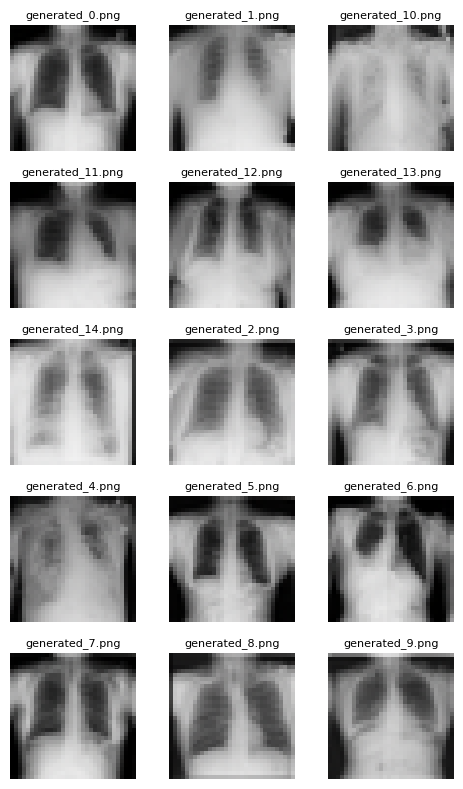

In [80]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define the folder where images are saved
folder = "update_generated_images"

# List only files (skip directories)
files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

# Sort files if needed and select the first 15
files = sorted(files)[:15]

# Create a grid of 5 rows and 3 columns
fig, axes = plt.subplots(5, 3, figsize=(5, 8))
axes = axes.flatten()

# Loop through each file and display the image
for i, file in enumerate(files):
    img_path = os.path.join(folder, file)
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(file, fontsize=8)

# Hide any remaining subplots if fewer than 15 images
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
